# 2D Gauss

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from astropy.modeling import powerlaws, fitting, models
#%matplotlib notebook
%matplotlib inline

## 2D Gaussian plot

In [40]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

# Create the gaussian data
Xin, Yin = np.mgrid[0:201, 0:201]
gdata = gaussian(30, 100, 100, 20, 20)(Xin, Yin) + np.random.random(Xin.shape)

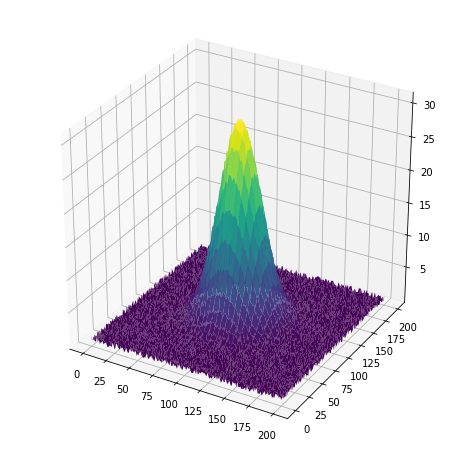

In [41]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Xin,Yin,gdata,cmap='viridis')
plt.show()

# LevMarLSQFitter 

### Example 1D [PowerLaw]

In [92]:
amplitude=20. 
x0 = 10.
alpha=2.

x = np.linspace(1,1000)
y = amplitude * (x/x0)**(-alpha)
plm = powerlaws.PowerLaw1D(1,1,1)
print("plm.params: ",plm)
fitter = fitting.LevMarLSQFitter()
result = fitter(plm, x, y)
print("Result: ",result)

plm.params:  Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude x_0 alpha
    --------- --- -----
          1.0 1.0   1.0
Result:  Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0               alpha       
    ------------------ ------------------ ------------------
    10.276822600307051 13.950364911173056 1.9999999999999998


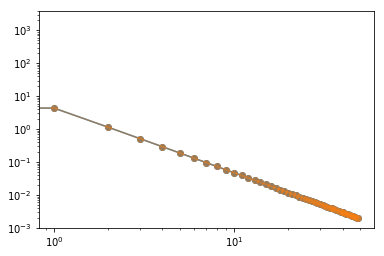

In [87]:
plt.loglog(y,'-o') ## Original 
plt.loglog(result(x),'-o',alpha=0.5) ##Fitted

### Example 2D [Gaussian]

In [20]:
## Input parameters:
amplitude = 30.
x_mean = 100.
y_mean = 100.
x_stddev = 20.
y_stddev = 20.
theta = 0.0
## 2D Gaussian using initial parameters:
g2di = models.Gaussian2D(amplitude, x_mean, y_mean, x_stddev, y_stddev, theta)
#print(g2di)
Xg, Yg = np.mgrid[0:201,0:201]
Zg = g2di(Xg, Yg)

#### Plot input Gauss2D

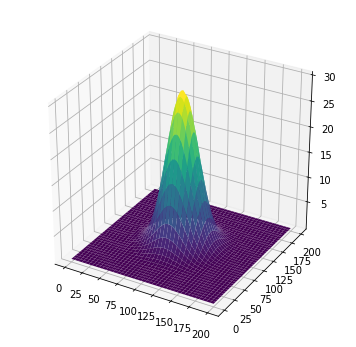

In [17]:
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot_surface(Xg,Yg,Zg,cmap='viridis')
plt.show()

#### Fitting Gauss 2D

In [116]:
## 2DGauss guess:
g2d_guess = models.Gaussian2D(10, 60, 130, 10, 5, 5)
print(g2d_guess)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
    amplitude x_mean y_mean x_stddev y_stddev theta
    --------- ------ ------ -------- -------- -----
         10.0   60.0  130.0     10.0      5.0   5.0


In [117]:
## Finding best fit:
fit2DG = fitting.LevMarLSQFitter()
g2d_out = fit2DG(g2d_guess,Xg,Yg,Zg)
print(g2d_out)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude      x_mean y_mean x_stddev y_stddev       theta      
    ------------------ ------ ------ -------- -------- -----------------
    29.999999999999996  100.0  100.0     20.0     20.0 5.849100903869146


#### Plot output Gauss2D

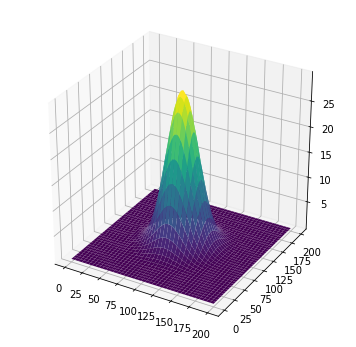

In [49]:
Zgo = g2d_out(Xg,Yg)
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot_surface(Xg,Yg,Zgo,cmap='viridis')
plt.show()

### Custom Model

#### Define 2 2DGaussians:

In [132]:
@models.custom_model
def TwoGaussians(x, y,
                 amp1 = 30.,x1_mean = 100.,y1_mean = 100., ## Gauss1 param
                 x1_stddev = 20.,y1_stddev = 20.,theta1 = 0.0,
                 amp2 = 30.,x2_mean = 100.,y2_mean = 100., ## Gauss2 param
                 x2_stddev = 20.,y2_stddev = 20.,theta2 = 0.0,):
    '''Define Sum of Gauss funtions'''
    g1 = models.Gaussian2D(amp1, x1_mean, y1_mean, x1_stddev, y1_stddev, theta1)
    g2 = models.Gaussian2D(amp2, x2_mean, y2_mean, x2_stddev, y2_stddev, theta2)
    return g1(x,y) + g2(x,y)

In [133]:
TwoGausser = TwoGaussians(amp2=10,x2_stddev = 2.,y2_stddev = 2.)
Zg2 = TwoGausser(Xg,Yg)

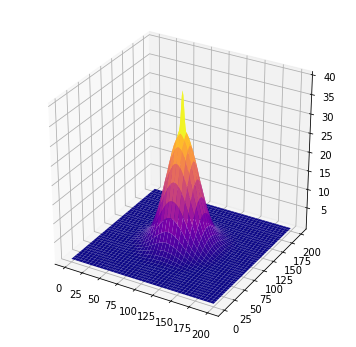

In [134]:
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot_surface(Xg,Yg,Zg2,cmap='plasma')
plt.show()

#### Fitting 2 2DGaussian:

In [166]:
## 2DGauss guess:
TG_guess = TwoGaussians(30, 100, 110, 10, 5, 5, 30, 100, 100, 5, 1, 5)
print(TG_guess)
## Finding best fit:
fit2DG = fitting.LevMarLSQFitter()
TG_out = fit2DG(TG_guess,Xg,Yg,Zg2,maxiter=120)
print(TG_out.param_names,TG_out.parameters)

Model: TwoGaussians
Inputs: ('x', 'y')
Outputs: ('x',)
Model set size: 1
Parameters:
    amp1 x1_mean y1_mean x1_stddev y1_stddev ... y2_mean x2_stddev y2_stddev theta2
    ---- ------- ------- --------- --------- ... ------- --------- --------- ------
    30.0   100.0   110.0      10.0       5.0 ...   100.0       5.0       1.0    5.0
('amp1', 'x1_mean', 'y1_mean', 'x1_stddev', 'y1_stddev', 'theta1', 'amp2', 'x2_mean', 'y2_mean', 'x2_stddev', 'y2_stddev', 'theta2') [ 30.00054044  99.99997103 100.00000084  19.99982451  19.99982923
   4.84612471   9.98662653 100.00150245  99.99997304   1.99801061
   1.99728612   4.82420018]


#### Plot 2 Gauss Fit outcome

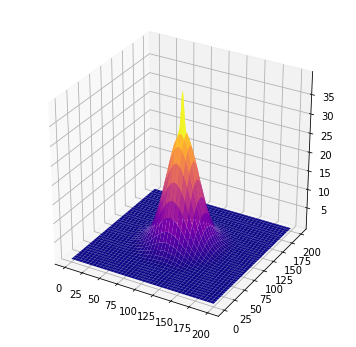

In [167]:
ZTG = TG_out(Xg,Yg)
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot_surface(Xg,Yg,ZTG,cmap='plasma')
plt.show()

##### Plot 2 Gauss Fit residue

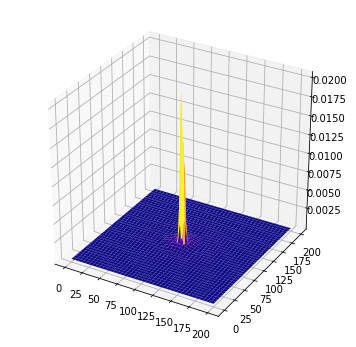

In [168]:
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot_surface(Xg,Yg,np.abs(ZTG-Zg2),cmap='plasma')
plt.show()

In [169]:
np.abs(ZTG-Zg2).max()

0.020331391933041232